# Regressão dos pixels amarelos

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import sys
import math
import os
print ("OpenCV Version : %s " % cv2.__version__)
print("Trabalhando em: ", os.getcwd())

OpenCV Version : 4.5.1 
Trabalhando em:  C:\Users\mirwo\robot\src\Aula-3


# 4. Aproximar faixa amarela por uma reta e direção

Você deve:
aproximar a faixa amarela do centro da pista por uma única reta

Para isso sugerimos que faça uma *regressão*  das coordenadas de onde os pixels são amarelos

Em seguida use este resultado para também esterçar o robô

In [2]:
def morpho_limpa(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    mask = cv2.morphologyEx( mask, cv2.MORPH_OPEN, kernel )
    mask = cv2.morphologyEx( mask, cv2.MORPH_CLOSE, kernel )    
    return mask


def multiplot(imgs, legenda="No sub"):
    """ Função """
    fig, axes = plt.subplots(1,len(imgs), figsize=(24,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(imgs[0],  vmin=0, vmax=255, cmap="Greys_r")
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")
        
        
# Função centro de massa baseada na aula 02  https://github.com/Insper/robot202/blob/master/aula02/aula02_Exemplos_Adicionais.ipynb
# Esta função calcula centro de massa de máscara binária 0-255 também, não só de contorno
def center_of_mass(mask):
    """ Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
    M = cv2.moments(mask)
    # Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [int(cX), int(cY)]

def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,3)
    cv2.line(img,(x,y - size),(x, y + size),color,3)
    

# Valores para amarelo usando um color picker

low = (25, 50, 50)
high = (35, 255, 255)

def segmenta_linha_amarela_bgr(bgr, low, high):
    """ REturns a mask within the range"""
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, low, high)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    mask = cv2.morphologyEx( mask, cv2.MORPH_OPEN, kernel )
    mask = cv2.morphologyEx( mask, cv2.MORPH_CLOSE, kernel )
    return mask    


def segmenta_linha_amarela_hsv(hsv, low, high):
    """ REturns a mask within the range"""
    mask = cv2.inRange(hsv, low, high)
    return mask    



In [3]:
frames_full = """frame0004.png  frame0476.png  frame1076.png  frame4256.png  frame5832.png  frame6928.png
frame0160.png  frame0916.png  frame4164.png  frame4624.png  frame5868.png"""

frames = """frame0004.png   frame5832.png  
    frame4164.png  """

frames = frames_full

In [4]:
frames = frames.split()

In [5]:
import os.path
bgr_frames = [cv2.imread(os.path.join("yellow_lane",f)) for f in frames]

In [6]:
rgb_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in bgr_frames]

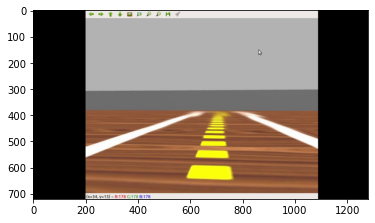

In [7]:
plt.imshow(rgb_frames[0])

In [8]:
crop = [frame[40:-40,:] for frame in rgb_frames]

In [9]:
hsv = [cv2.cvtColor(c, cv2.COLOR_RGB2HSV) for c in crop]

In [10]:
mask_y = [segmenta_linha_amarela_hsv(h, low, high) for h in hsv]

In [11]:
mask_y = [morpho_limpa(m) for m in mask_y]

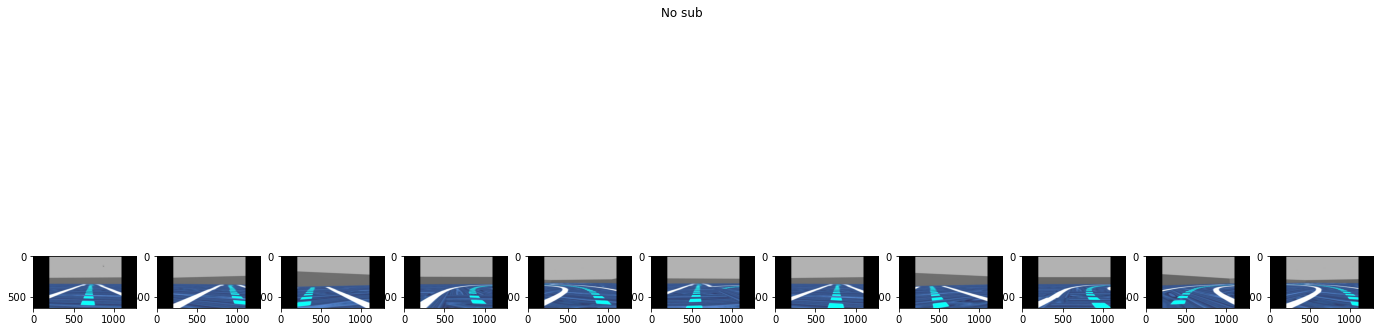

In [12]:
multiplot(crop)

In [13]:
mask_rgb = [cv2.cvtColor(c, cv2.COLOR_GRAY2RGB) for c in mask_y]

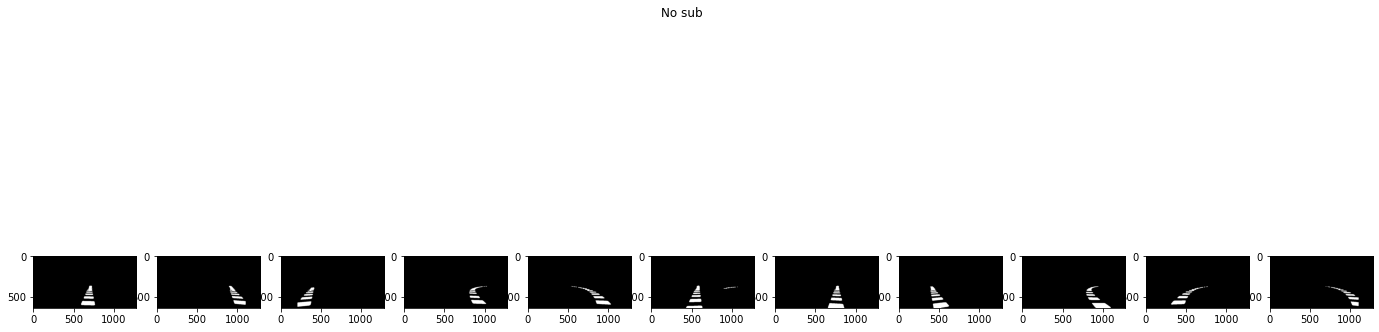

In [14]:
multiplot(mask_rgb)

## Testando o statsmodels

In [15]:
x = np.arange(0,100)

In [16]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [17]:
y = 2*x+10

In [18]:
import statsmodels.api as sm

xc = sm.add_constant(x)
#xc = x
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.493e+32
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:21:38   Log-Likelihood:                 2992.6
No. Observations:                 100   AIC:                            -5981.
Df Residuals:                      98   BIC:                            -5976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0000   4.89e-15   2.05e+15      0.000      10.000      10.000
x1             2.0000   8.53e-17   2.34e+16      0.000       2.000       2.000
==============================================================================
Omnibus:                       20.197   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.897
Skew:                          -0.942   Prob(JB):                     5.31e-07
Kurtosis:                       4.840   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
from sklearn.linear_model import LinearRegression


In [20]:
lm = LinearRegression()

xr = x.reshape(-1, 1)

yr = y.reshape(-1,1)

lm.fit(yr,xr)

LinearRegression()

In [21]:
xt = np.array([200])
xt = xt.reshape(-1,1)

lm.predict(xt)

array([[95.]])

In [22]:
teste = mask_y[1]

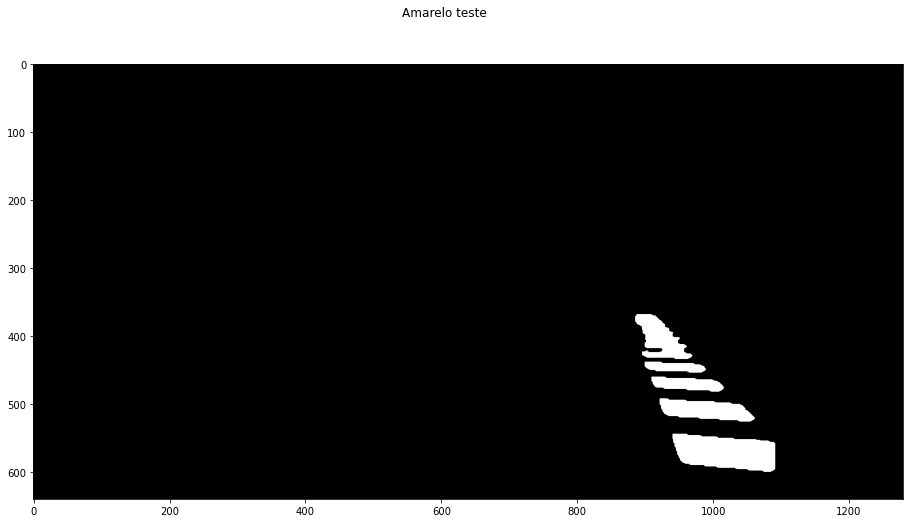

In [23]:
multiplot_gray([teste], "Amarelo teste")

In [24]:
def ajuste_linear_x_fy(mask):
    """Recebe uma imagem já limiarizada e faz um ajuste linear
        retorna coeficientes linear e angular da reta
        e equação é da forma
        y = coef_angular*x + coef_linear
    """ 
    pontos = np.where(mask==255)
    ximg = pontos[1]
    yimg = pontos[0]
    yimg_c = sm.add_constant(yimg)
    model = sm.OLS(ximg,yimg_c)
    results = model.fit()
    coef_angular = results.params[1] # Pegamos o beta 1
    coef_linear =  results.params[0] # Pegamso o beta 0
    return coef_angular, coef_linear

def ajuste_linear(mask):
    """Recebe uma imagem já limiarizada e faz um ajuste linear
        retorna coeficientes linear e angular da reta
        e equação é da forma
        y = coef_angular*x + coef_linear
    """ 
    pontos = np.where(mask==255)
    ximg = pontos[1]
    yimg = pontos[0]
    yimg_c = sm.add_constant(yimg)
    ximg_c = sm.add_constant(ximg)
    model = sm.OLS(yimg,ximg_c)
    results = model.fit()
    coef_angular = results.params[1] # Pegamos o beta 1
    coef_linear =  results.params[0] # Pegamso o beta 0
    return coef_angular, coef_linear


In [25]:
   
def ajuste_linear_grafico_x_fy(mask):
    """Faz um ajuste linear e devolve uma imagem rgb com aquele ajuste desenhado sobre uma imagem"""
    coef_angular, coef_linear = ajuste_linear_x_fy(mask)
    print("x = {:3f}*y + {:3f}".format(coef_angular, coef_linear))
    pontos = np.where(mask==255) # esta linha é pesada e ficou redundante
    ximg = pontos[1]
    yimg = pontos[0]
    y_bounds = np.array([min(yimg), max(yimg)])
    x_bounds = coef_angular*y_bounds + coef_linear
    print("x bounds", x_bounds)
    print("y bounds", y_bounds)
    x_int = x_bounds.astype(dtype=np.int64)
    y_int = y_bounds.astype(dtype=np.int64)
    mask_rgb =  cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    cv2.line(mask_rgb, (x_int[0], y_int[0]), (x_int[1], y_int[1]), color=(0,0,255), thickness=11);    
    return mask_rgb

In [26]:
ajustes_rgb =[ ajuste_linear_grafico_x_fy(img) for img in mask_y]

x = -0.124326*y + 750.422510
x bounds [705.04336858 674.95637614]
y bounds [365 607]
x = 0.593003*y + 682.616104
x bounds [ 900.84131723 1037.82507852]
y bounds [368 599]
x = -0.522740*y + 589.263558
x bounds [387.48578499 263.07358289]
y bounds [386 624]
x = 0.271319*y + 752.605959
x bounds [852.99409718 912.4130221 ]
y bounds [370 589]
x = 1.269624*y + 207.275806
x bounds [677.03651613 966.51068356]
y bounds [370 598]
x = -0.597753*y + 886.865840
x bounds [669.28390027 504.90194049]
y bounds [364 639]
x = -0.066663*y + 790.584023
x bounds [766.18519645 747.98607198]
y bounds [366 639]
x = 0.455356*y + 232.685485
x bounds [402.98846902 523.65769589]
y bounds [374 639]
x = 0.718671*y + 527.039112
x bounds [794.38487654 986.27014301]
y bounds [372 639]
x = -1.208891*y + 1083.293887
x bounds [631.16872201 361.58607003]
y bounds [374 597]
x = 1.087901*y + 434.275436
x bounds [ 838.97478553 1103.33484451]
y bounds [372 615]


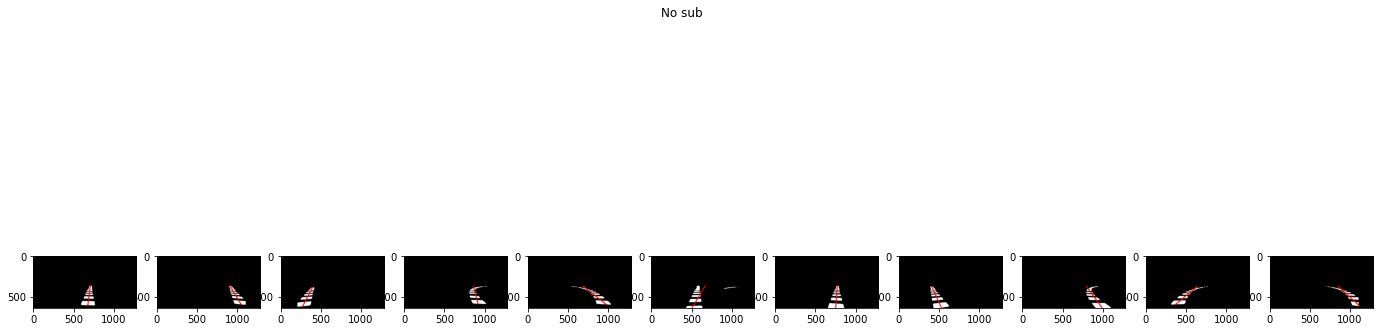

In [27]:
multiplot(ajustes_rgb)

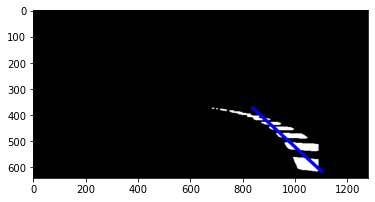

In [115]:
c=0
for img in ajustes_rgb:
    cv2.imwrite("ajuste{0:03d}.jpg".format(c), img)    
    plt.imshow(img)
    c+=1

In [29]:
!explorer .

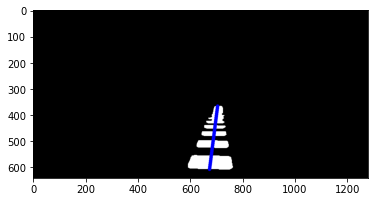

In [117]:
plt.imshow(ajustes_rgb[0])

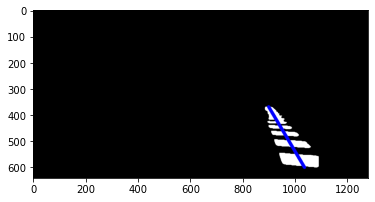

In [118]:
plt.imshow(ajustes_rgb[1])

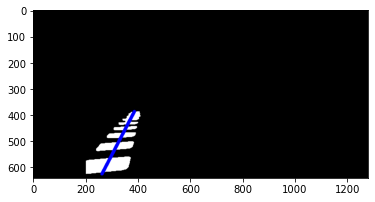

In [119]:
plt.imshow(ajustes_rgb[2])

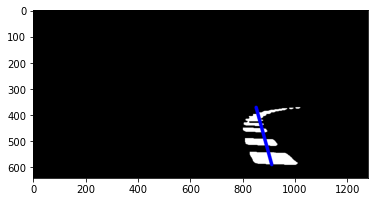

In [120]:
plt.imshow(ajustes_rgb[3])